# Imports

In [1]:
import numpy as np
import pandas as pd
np.random.seed(2121)

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV, Lasso
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

In [2]:
batpos = pd.read_csv('../data/batpos_full_preprocessed.csv')
baseline = pd.read_csv('../data/X_test_full_for_baseline.csv')

In [3]:
# set our index
for df in [batpos,baseline]:
    df.set_index('Unnamed: 0', inplace=True)
    df.index.name = None

In [4]:
# decompose into X and y, test and train
target = 'waa_pg'

y_train = batpos[batpos.is_train==1][target]
X_train = batpos[batpos.is_train==1]\
            [[c for c in batpos.columns if c != target]]

y_test = batpos[batpos.is_train==0][target]
X_test = batpos[batpos.is_train==0]\
            [[c for c in batpos.columns if c != target]]

In [5]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs, label = 'Actual = Predicted')
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

# source:
# https://stackoverflow.com/questions/22104256/does-matplotlib-have-a-function-for-drawing-diagonal-lines-in-axis-coordinates

# Baseline

Our baseline for modeling will be a more intuitive feeling one: the weighted average of the past three `waa_pg`. If asking how a player would perform, it would be reasonable to look closest at the last year, but also take the previous years into account with a marginal impact.

In [6]:
baseline1 = (baseline['waa_pg_1yr']*3 + baseline['waa_pg_2yr']*2\
                + baseline['waa_pg_3yr'])/6

In [7]:
# calculate baseline score
r2_score(y_test, baseline1)

0.2958886964785129

**Note** Our baseline value is <span style='color:blue'><u>**29.59%**</u></span>

A different baseline that can be looked at is the straight average

In [8]:
baseline2 = (baseline['waa_pg_1yr'] + baseline['waa_pg_2yr']\
                + baseline['waa_pg_3yr'])/3

In [9]:
# calculate baseline score
r2_score(y_test, baseline2)

0.2983743417468937

Lastly, just using the previous years value.

In [10]:
r2_score(y_test, baseline['waa_pg_1yr'])

0.059750008955404055

# Linear Regression

Start with a simple Linear Regression with no normalization.

In [11]:
# initialize
lr = LinearRegression()

# fit
lr.fit(X_train, y_train)

# score
lr.score(X_test,y_test)

0.39017970554780557

## Lasso Regularization

In [12]:
# initialize
lasso_cv = LassoCV()

# cv
scores = cross_val_score(lasso_cv, X_train, y_train)

# fit
lasso_cv.fit(X_train, y_train)

# best attributes
print(f'Best Alpha: {lasso_cv.alpha_:.4f}')
print(f'CV Score: {scores.mean():.4f}')

Best Alpha: 0.0003
CV Score: 0.3661


In [13]:
# generate features to select
lasso_cv.score(X_test,y_test)

0.3935131050271592

In [14]:
lasso_cols = [col for col, coef in zip(X_train.columns, lasso_cv.coef_) if coef]

In [15]:
lr.fit(X_train[lasso_cols], y_train)

lr.score(X_test[lasso_cols],y_test)

0.3914652994341199

Lasso feature selection increases our models score!

# Random Forest

In [16]:
# initialize
rf = RandomForestRegressor()

# fit
rf.fit(X_train, y_train)

# score
rf.score(X_test,y_test)

0.3594083911535262

**RUN THIS ONLY IF YOU WANT TO WAIT**

In [17]:
# param_grid = {'max_depth': [3,5,10],
#               'min_samples_split': [2,5,10]}

# rf = RandomForestRegressor(random_state=1212)

# sh = HalvingGridSearchCV(rf, param_grid, cv=5,
#                          factor=2, resource='n_estimators',
#                          min_resources=50,
#                          max_resources=1000, verbose=3)

# sh.fit(X_train, y_train)

In [18]:
# sh.best_params_

The results from the HGS are {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 400}

In [19]:
# initialize
rf = RandomForestRegressor(n_estimators=400,
                           max_depth=5,
                           min_samples_split=2)

# fit
rf.fit(X_train, y_train)

# score
rf.score(X_test,y_test)

0.3571247651873789

Our model actually got a lower score after the halving grid search!

# SVM

In [20]:
# initialize
svr = SVR()

# fit
svr.fit(X_train, y_train)

# score
svr.score(X_test,y_test)

-0.02602472079240159

**RUN THIS ONLY IF YOU WANT TO WAIT**

In [21]:
# param_grid = {'epsilon': np.logspace(-3,-1,3),
#               'C': np.logspace(-3,-1,3),
#               'gamma': ['scale','auto']}

# svr = SVR()

# gs = GridSearchCV(svr, param_grid, cv=5,
#                   verbose=3)

# gs.fit(X_train, y_train)

In [22]:
# gs.best_params_

Best params were {'C': 0.01, 'epsilon': 0.01, 'gamma': 'scale'}

In [23]:
# initialize
svr = SVR(C=0.01, epsilon = 0.01, gamma = 'scale')

# fit
svr.fit(X_train, y_train)

# score
svr.score(X_test,y_test)

0.34022866463091095

The worst model so far. Grid search did help improve the score though drastically!

# Results

The Linear Regression using Lasso Feature Selection scored the highest among the models.

In [24]:
# import our un-standard scaled dataframe to convert standard devs to units if needed

batpos_full = pd.read_csv('../data/batpos_full_feature_extracted.csv')

In [25]:
# generate std and mean list for our coef df
std_lst=[]
mean_lst=[]
for c in lasso_cols:
    try:
        std_lst.append(batpos_full[c].describe()['std'])
        mean_lst.append(batpos_full[c].describe()['mean'])
    except: 
        std_lst.append(np.nan)
        mean_lst.append(np.nan)

coef_df = pd.concat([pd.Series(lr.coef_, index=lasso_cols, name='coef'),
                     pd.Series(std_lst, index=lasso_cols, name='std'),
                     pd.Series(mean_lst, index=lasso_cols, name='mean')],
              axis=1).sort_values(by='coef', ascending=False)

In [26]:
coef_df

,coef,std,mean
waa_pg_1yr,0.003937,0.014730,0.010942
waa_pg_2yr,0.003771,0.014291,0.011743
waa_pg_3yr,0.001398,0.013975,0.012090
runs_bat_pg_3yr,0.001133,0.129549,0.097450
runs_bat_pg_1yr,0.000713,0.132802,0.096474
g_c_share_1yr,0.000685,0.179132,0.036409
runs_dp_pg_2yr,0.000659,0.010386,-0.000259
runs_br_pg_1yr,0.000458,0.020036,0.006157
pc_3,0.000078,NaN,NaN
pc_0,-0.000271,NaN,NaN


The most important features by far are the waa_pg_\*_yr variables. They have similar standard deviations to one another so it is fair to say that `waa_pg_1yr` is 1.2 times more impactful than `waa_pg_2yr` and 1.5 times more than `waa_pg_3yr`.

`age` is the most negatively impactful feature with a per-year effect around the effect of 0.18 standard deviations of `waa_pg_1yr`

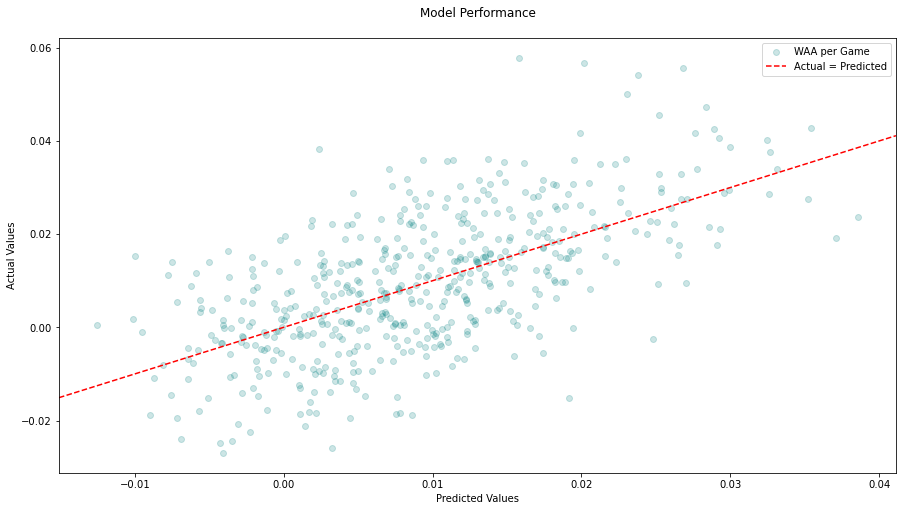

In [27]:
predictions  =  lr.predict(X_test[lasso_cols])

# Plot the model
figure, ax = plt.subplots(1,1,figsize=(15,8))


ax.scatter(predictions, y_test, alpha = 0.2, color='teal', label = 'WAA per Game')
ax.set_title('Model Performance\n')
ax.set_xlabel("Predicted Values")
ax.set_ylabel("Actual Values")
add_identity(ax, color = 'r', ls='--')
ax.legend();

**Observation** This is very blobby unfortunately. A model score of 39% does not make this completely unsurprising. Some missed signal around predicted 0.02 to 0.03 and actual 0.04 and 0.06.

# Conclusions

So many things can be added to this model to try and capture additional noise. The most surprising thing was the poor performance of the RDF models. It would seem that the previous 3 years of a player's career would be a good indicator for future performance, but it just wasn't the case. Looking deeper into the nuts and bolts of the normalizing that Baseball-Reference does could also help tighten the model--there may be more at play with the league environmental variables beyond just the average amount of runs being scored per game. Applying more statsitics could also help; there may be some signal captured by including more traditional metrics like RBIs and HRs.

Future work on this would include adding pitchers as well as adding the ability to forecast beyond one year. This would allow for evaluation of players over a more traditionally-lengthed contract like 2-3 years.